# Modifying a SMIRNOFF force field

In this example, we'll parameterize a ligand automatically, and then play with its parameters to demonstrate the Toolkit's ability to facilitate force field optimization. For each modification, we'll calculate the energy for the original conformation, and then minimize the energy and visualize the result.

In [1]:
from copy import deepcopy

from openff.units import unit
from openff.units.openmm import from_openmm, to_openmm
from openmm import LangevinIntegrator, app
from openmm import unit as openmm_unit

import openff.toolkit.typing.engines.smirnoff.parameters as offtk_parameters
from openff.toolkit import ForceField, Molecule

We're going to do a lot of changing a parameter and then visualising what happened, so let's define a convenience function to do just that

In [2]:
def minimize_and_visualize(molecule, forcefield):
    # Sort out our input data
    mol_topology = molecule.to_topology()
    mol_system = forcefield.create_openmm_system(
        mol_topology,
        charge_from_molecules=[molecule],
    )

    # Set up the minimization and point calculation
    integrator = LangevinIntegrator(
        300 * openmm_unit.kelvin,
        1 / openmm_unit.picosecond,
        0.002 * openmm_unit.picoseconds,
    )
    simulation = app.Simulation(mol_topology.to_openmm(), mol_system, integrator)
    simulation.context.setPositions(to_openmm(molecule.conformers[0]))

    # Get the initial energy
    initial_potential = simulation.context.getState(getEnergy=True).getPotentialEnergy()

    # Energy minimize
    simulation.minimizeEnergy()
    minimized_state = simulation.context.getState(getPositions=True, getEnergy=True)
    minimized_potential = minimized_state.getPotentialEnergy()
    minimized_coords = from_openmm(minimized_state.getPositions(asNumpy=True))

    # Visualize
    vis_mol = deepcopy(molecule)
    vis_mol.conformers[0] = minimized_coords
    view = vis_mol.visualize(backend="nglview")
    print(
        f"Initial energy is {initial_potential.format('%0.1F')};",
        f"Minimized energy is {minimized_potential.format('%0.1F')}",
    )
    return view

## Getting to know you — the molecule

This "ligand" is a modified version of the molecule we introduced in the Toolkit Showcase. It's just been altered for a slightly more exciting example here. This also lets us demonstrate constructing a `Molecule` from a SMILES string!

In [3]:
ligand_smiles = "CC(C)(C)c1c(O)c(O)c2c(c1O)[C@H]1OCCC[C@H]1[C@H](c1cc(O)c(O)c(F)c1)N2"
ligand = Molecule.from_smiles(ligand_smiles)
ligand.generate_conformers(n_conformers=1)
force_field = ForceField("openff-2.0.0.offxml")

Computing charges is expensive, and we're going to be changing the force field a lot, so we can save time by computing them just once and caching them.


<div class="alert alert-info" style="max-width: 700px; margin-left: auto; margin-right: auto;">
    ℹ️ Note that when we call <code>create_openmm_system</code> above we pass
    in the charges with the <code>charge_from_molecules</code> argument!
</div>

In [4]:
ligand.partial_charges = force_field.get_partial_charges(ligand)

### The ligand, visualised

Let's take a close look at the ligand and decide what we want to modify. We'll label the atoms with their indexes so we can identify them later

In [5]:
view = minimize_and_visualize(ligand, force_field)
view.add_label(label_type="atomindex", color="black", attachment="middle-center")
view

Initial energy is 270.8 kJ/mol; Minimized energy is 82.3 kJ/mol


NGLWidget()

## Getting to know all about you — Investigating assigned parameters

Let's start with something simple — lengthening the bond to the fluorine. We can use `ForceField.label_molecules` to identify the appropriate parameters:

In [6]:
ff_applied_parameters = force_field.label_molecules(ligand.to_topology())
ff_applied_parameters

[{'Constraints': <openff.toolkit.topology.topology.ValenceDict at 0x17e4bbee0>,
  'Bonds': <openff.toolkit.topology.topology.ValenceDict at 0x17e4bbf70>,
  'Angles': <openff.toolkit.topology.topology.ValenceDict at 0x17dbe5760>,
  'ProperTorsions': <openff.toolkit.topology.topology.ValenceDict at 0x10f8decd0>,
  'ImproperTorsions': <openff.toolkit.topology.topology.ImproperDict at 0x17e4d6eb0>,
  'vdW': <openff.toolkit.topology.topology.ValenceDict at 0x17e470be0>,
  'Electrostatics': <openff.toolkit.topology.topology.ValenceDict at 0x17dc0b520>,
  'LibraryCharges': {},
  'ToolkitAM1BCC': <openff.toolkit.topology.topology.ValenceDict at 0x17e4b1d30>}]

`label_molecules()` returns a list of the molecules that can be parameterized from the arguments. It returns them as dictionaries that give us access to the `ForceField` parameters that are used for the molecule. Since we're only passing in a single molecule, `ff_applied_parameters` is a list of one element. We can see the bonds that are used for the ligand by converting the appropriate `ValenceDict` to a regular dictionary:

In [7]:
dict(ff_applied_parameters[0]["Bonds"])

{(0,
  1): <BondType with smirks: [#6X4:1]-[#6X4:2]  id: b1  length: 1.52190126495 angstrom  k: 529.2429715351 kilocalorie / angstrom ** 2 / mole  >,
 (0,
  33): <BondType with smirks: [#6X4:1]-[#1:2]  id: b84  length: 1.093899492634 angstrom  k: 740.0934137725 kilocalorie / angstrom ** 2 / mole  >,
 (0,
  34): <BondType with smirks: [#6X4:1]-[#1:2]  id: b84  length: 1.093899492634 angstrom  k: 740.0934137725 kilocalorie / angstrom ** 2 / mole  >,
 (0,
  35): <BondType with smirks: [#6X4:1]-[#1:2]  id: b84  length: 1.093899492634 angstrom  k: 740.0934137725 kilocalorie / angstrom ** 2 / mole  >,
 (1,
  2): <BondType with smirks: [#6X4:1]-[#6X4:2]  id: b1  length: 1.52190126495 angstrom  k: 529.2429715351 kilocalorie / angstrom ** 2 / mole  >,
 (1,
  3): <BondType with smirks: [#6X4:1]-[#6X4:2]  id: b1  length: 1.52190126495 angstrom  k: 529.2429715351 kilocalorie / angstrom ** 2 / mole  >,
 (1,
  4): <BondType with smirks: [#6X4:1]-[#6X3:2]  id: b2  length: 1.498646816465 angstrom  k: 

Take a look at the first entry as an example. The dictionary is keyed by the atomic indices of the particles in the molecule that the parameter applies to, and the values are special types that specify the parameters from the force field. We'll look in more detail at one of these parameters in a second.

## A little goes a long way — Changing parameters

We already decided we wanted to adjust the torsion parameter to the hydroxyl group, so let's do that. We know parameters are indexed by the atoms they've been applied to, so we can look at our labelled widget above and pull out exactly the parameter we care about:

In [8]:
fluorine = [atom for atom in ligand.atoms if atom.symbol == "F"][0]
carbon = [neighbor_atom for neighbor_atom in fluorine.bonded_atoms][0]
fluorine_carbon_bond_indices = (
    fluorine.molecule_atom_index,
    carbon.molecule_atom_index,
)
print("The fluorine-carbon bond is between atoms", fluorine_carbon_bond_indices)

ff_applied_parameters[0]["Bonds"][fluorine_carbon_bond_indices]

The fluorine-carbon bond is between atoms (30, 29)


<BondType with smirks: [#6:1]-[#9:2]  id: b68  length: 1.352926211207 angstrom  k: 808.7710029616 kilocalorie / angstrom ** 2 / mole  >

<div class="alert alert-success" style="max-width: 700px; margin-left: auto; margin-right: auto;">
    📗 We have to get the indices of these atoms out programmatically because our SMILES code doesn't specify atom indices, and so you might have different indices to us. Take a look at the widget above and try manually specifying atom indices to get the parameters of a bond! 
</div>

Let's dig into this type a bit more. It has a few attributes in its textual representation. The first of these is maybe the most important: the `smirks` attribute, which tells the Toolkit which atoms this parameter applies to. SMIRKS is a chemical pattern matching format; think of it as the result of a [regular expression](https://en.wikipedia.org/wiki/Regular_expression) having a baby with a [SMILES string](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system). This one is very simple: it is just a Carbon atom (`[#6:1]`, atomic number 6) singly bonded (`-`) to a Fluorine atom (`[#9:2]`, atomic number 9). The numbers after the colons just label the atoms — this is a bond, so it has two atoms labelled. This is helpful for when we want to match against atoms that aren't a part of the parameter; we just don't label the additional atoms. We'll use this trick later.

The other important attributes provide the actual parameterization, and so are different for different kinds of parameters. For proper torsions, this is the periodicity of the sinewave that describes the torsion, as well as its phase and amplitude (or force constant, $k$). These parameter values are similar to the equivalent description in most other force field formats.


<div class="alert alert-info" style="max-width: 700px; margin-left: auto; margin-right: auto;">
    <p> ℹ️ The SMIRKS specification is available online:</p>
    <p style="margin-left:3em;">
        <a href=https://www.daylight.com/dayhtml/doc/theory/theory.smirks.html>
            https://www.daylight.com/dayhtml/doc/theory/theory.smirks.html
        </a>
    </p>
    <p style="margin-left:1.5em;">
        It is closely related to the SMARTS molecular pattern matching language, 
        whose specification is probably more useful for working with the Toolkit
        and is also available online:
    </p>
    <p style="margin-left:3em;">
        <a href = https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html>
            https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html
        </a>
    </p>
</div>


### Modifying a parameter

Unfortunately we can't just modify this parameter and see the results reflected in the parameterization. We need to get the appropriate parameter from the force field and modify it there.

In [9]:
fluorine_bond = force_field["Bonds"].parameters["[#6:1]-[#9:2]"]
fluorine_bond.length = 10 * unit.angstrom

Here, we've selected the proper torsion with the SMIRKS code we found earlier, and changed its force constant by an order of magnitude in the opposite direction! Let's see what we've wrought:

In [10]:
minimize_and_visualize(ligand, force_field)

Initial energy is 127153.9 kJ/mol; Minimized energy is 99.8 kJ/mol


NGLWidget()

Turns out Pinocchio was a real molecule all along!

### Parameters affecting multiple atom groups

Ok, that was fun, but it's only one parameter; we could easily have made this change in the OpenMM `System` or a GROMACS ITP file or whatever. What's the toolkit really giving us here?

Let's mess with all the H-X-H angles. And let's not get into SMIRKS this time, lets let the toolkit do the thinking:

In [11]:
ff_applied_parameters = force_field.label_molecules(ligand.to_topology())
for atoms, parameter in ff_applied_parameters[0]["Angles"].items():
    ele_1 = ligand.atoms[atoms[0]].symbol
    ele_2 = ligand.atoms[atoms[1]].symbol
    ele_3 = ligand.atoms[atoms[2]].symbol
    if ele_1 == "H" and ele_3 == "H":
        print(atoms, parameter)

(33, 0, 34) <AngleType with smirks: [#1:1]-[#6X4:2]-[#1:3]  angle: 115.6030999533 degree  k: 97.55298529519 kilocalorie / mole / radian ** 2  id: a2  >
(33, 0, 35) <AngleType with smirks: [#1:1]-[#6X4:2]-[#1:3]  angle: 115.6030999533 degree  k: 97.55298529519 kilocalorie / mole / radian ** 2  id: a2  >
(34, 0, 35) <AngleType with smirks: [#1:1]-[#6X4:2]-[#1:3]  angle: 115.6030999533 degree  k: 97.55298529519 kilocalorie / mole / radian ** 2  id: a2  >
(36, 2, 37) <AngleType with smirks: [#1:1]-[#6X4:2]-[#1:3]  angle: 115.6030999533 degree  k: 97.55298529519 kilocalorie / mole / radian ** 2  id: a2  >
(36, 2, 38) <AngleType with smirks: [#1:1]-[#6X4:2]-[#1:3]  angle: 115.6030999533 degree  k: 97.55298529519 kilocalorie / mole / radian ** 2  id: a2  >
(37, 2, 38) <AngleType with smirks: [#1:1]-[#6X4:2]-[#1:3]  angle: 115.6030999533 degree  k: 97.55298529519 kilocalorie / mole / radian ** 2  id: a2  >
(39, 3, 40) <AngleType with smirks: [#1:1]-[#6X4:2]-[#1:3]  angle: 115.6030999533 degree

Wow, there's just one `smirks` parameter describing all of the H-X-H angles!

<div class="alert alert-info" style="max-width: 700px; margin-left: auto; margin-right: auto;">
    ℹ️ It's worth mentioning here that a force field might include multiple parameters with SMIRKS that match a particular group of atoms. When this happens, only the last parameter specified is applied. This allows force field authors to define general parameters first, and then override them with more specific parameters.
</div>

<div class="alert alert-success" style="max-width: 700px; margin-left: auto; margin-right: auto;">
    📗 Convince yourself that this SMIRKS code matches all of the H-X-H angles in our molecule. What H-X-H angles would it not match?
</div>


In [12]:
hxh_angle = force_field["Angles"].parameters["[#1:1]-[#6X4:2]-[#1:3]"]
hxh_angle.angle = 50 * unit.degree

minimize_and_visualize(ligand, force_field)

Initial energy is 129550.3 kJ/mol; Minimized energy is 113.7 kJ/mol


NGLWidget()

That is not how a methyl group is supposed to look. Guess we did it right!

## Introducing a new parameter

Now let's get really crazy. I've always thought heteroatoms in rings looked a bit too comfortable, haven't you?

Since we have two cyclic heteroatoms in our molecule with very different chemistries, there'll probably be two seperate parameters we need to modify. We can just pass the SMIRKS that come up for C-X-C angles to code that modifies the parameters directly, no need to manually copy it over. 

In [13]:
ff_applied_parameters = force_field.label_molecules(ligand.to_topology())
for atoms, parameter in ff_applied_parameters[0]["Angles"].items():
    ele_1 = ligand.atoms[atoms[0]].symbol
    ele_2 = ligand.atoms[atoms[1]].symbol
    ele_3 = ligand.atoms[atoms[2]].symbol
    if (ele_2 not in ["C", "H"]) and ele_1 == "C" and ele_3 == "C":
        print(atoms, parameter)

        smirks = parameter.smirks
        heteroatom_angle = force_field["Angles"].parameters[smirks]
        # dihedral angles are undefined when linear, so let's not set to 180
        heteroatom_angle.angle = 179 * unit.degree

        # We'll need this later
        if ele_2 == "N":
            cyclic_nitrogen_smirks = smirks

minimize_and_visualize(ligand, force_field)

(9, 32, 21) <AngleType with smirks: [*:1]~[#7X3$(*~[#6X3,#6X2,#7X2+0]):2]~[*:3]  angle: 117.3465570514 degree  k: 110.8436430155 kilocalorie / mole / radian ** 2  id: a20  >
(13, 15, 16) <AngleType with smirks: [*:1]-[#8:2]-[*:3]  angle: 110.3538806181 degree  k: 130.181232192 kilocalorie / mole / radian ** 2  id: a28  >
Initial energy is 132119.8 kJ/mol; Minimized energy is 400.5 kJ/mol


NGLWidget()

Oops! We didn't mean to make all the hydroxyl groups linear! One of our parameters must be applied to Oxygen both when its in a ring and in a hydroxyl group. Sure enough, the second SMIRKS code printed above (`[*:1]-[#8:2]-[*:3]`) matches any X-O-X angle! We'll have to define a new, more specific SMIRKS entry so we only capture the appropriate oxygen.

### The SMIRKS for our new parameter

Our modified force field is getting a bit messy, so let's start again. We still want the nitrogen angle from before, so lets save that too

In [14]:
force_field = ForceField("openff-2.0.0.offxml")
cyclic_nitrogen_angle = force_field["Angles"].parameters[cyclic_nitrogen_smirks]
cyclic_nitrogen_angle.angle = 179 * unit.degree

Now we need to define a new SMIRKS entry, specific to oxygens in a ring. We can be as specific as we like, as our new parameter will be at the end of the force field and so will override any conflicting parameters. Let's define our smirks to match any singly-bonded C-O-C angle in a six-membered pyran ring.

First, we'll write down the SMILES for a pyran:

`C1CCOCC1`

The first carbon has a digit following it, `C1`, which allows us to close the ring later. Then we have two more carbons, `CC`, an oxygen, `O`, and the final two carbons, `CC`. Finally, we close the ring by repeating the same digit from before, `1`. Lets check that this produces the chemical we expect before we move on:

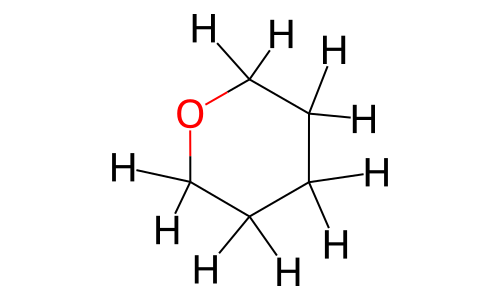

In [15]:
Molecule.from_smiles("C1CCOCC1").visualize()

Perfect. We can ignore the hydrogens, as we haven't specified any bond orders - our smirks will match the saturated structure or any of its derivatives that maintain the ring. Now all we have to do is label the atoms we want to extract the bond from! This way, all the atoms must be present for the SMIRKS to match, but only these three atoms define the angle for the parameter. This lets us be more specific than we could be if we could only describe the atoms in the angle itself. We do that the same way we did before, put them in square brackets and append a colon and a number:

In [16]:
cyclic_oxygen_smirks = "C1C[C:1]-[O:2]-[C:3]C1"


<div class="alert alert-success" style="max-width: 700px; margin-left: auto; margin-right: auto;">
    📗 Try replacing this SMIRKS code with one of your own. Hint: For this force field and ligand, there's a much simpler code that will uniquely specify the C-O-C bond!
</div>


### Defining and registering the new parameter

Now, all that's left is to define the angle parameter, add it to the force field, and see what we've wrought!

In [17]:
# Define the new angle parameter
angle_parameter = offtk_parameters.AngleHandler.AngleType(
    smirks=cyclic_oxygen_smirks,
    angle=179 * unit.degree,
    k=134.5019777341 * unit.kilocalorie / (unit.mole * unit.radians**2),
)

# Add the parameter to the force field
angles_handler = force_field["Angles"]
angles_handler.add_parameter(parameter=angle_parameter)

# Visualize the newly parameterized molecule
minimize_and_visualize(ligand, force_field)

Initial energy is 883.2 kJ/mol; Minimized energy is 300.5 kJ/mol


NGLWidget()

Perfect! The two cyclic heteroatoms are nearly linear while the hydroxyl group retains its characteristic angle.

### Bonus: Adding a cosmetic attribute to the new parameter

In some cases, you might want to tag a particular attribute with extra data. This might be useful, for example, in communicating to a fitting tool which parameters should be fitted, or simply to add extra metadata.. The toolkit allows for _cosmetic attributes_, which can be stored to individual parameters, will be included out when the `ForceField` object is written to disk, but will not otherwise affect the parameterization machinery. The API point for this is [`ParameterType.add_cosmetic_attribute`](https://docs.openforcefield.org/projects/toolkit/en/stable/api/generated/openff.toolkit.typing.engines.smirnoff.parameters.ParameterType.html#openff.toolkit.typing.engines.smirnoff.parameters.ParameterType.add_cosmetic_attribute).

Let's use this to tag our modified and new parameters with a note about why we introduced it.

In [18]:
angles_handler.parameters[cyclic_nitrogen_smirks].add_cosmetic_attribute(
    attr_name="note",
    attr_value="funky pseudo-linear cyclic nitrogen",
)

angles_handler.parameters[cyclic_oxygen_smirks].add_cosmetic_attribute(
    attr_name="note",
    attr_value="funky pseudo-linear cyclic oxygen",
)

We we look at these parameter now, they include this attribute tacked on at the end:

In [19]:
angles_handler.parameters[cyclic_nitrogen_smirks]

<AngleType with smirks: [*:1]~[#7X3$(*~[#6X3,#6X2,#7X2+0]):2]~[*:3]  angle: 179 degree  k: 110.8436430155 kilocalorie / mole / radian ** 2  id: a20  note: funky pseudo-linear cyclic nitrogen  >

In [20]:
angles_handler.parameters[cyclic_oxygen_smirks]

<AngleType with smirks: C1C[C:1]-[O:2]-[C:3]C1  angle: 179 degree  k: 134.5019777341 kilocalorie / mole / radian ** 2  note: funky pseudo-linear cyclic oxygen  >

Cometic attributes are included by default when [writing to disk](https://docs.openforcefield.org/projects/toolkit/en/stable/api/generated/openff.toolkit.typing.engines.smirnoff.ForceField.html#openff.toolkit.typing.engines.smirnoff.ForceField.to_file). (This can be turned off by flipping the argument `discard_cosmetic_attributes` to `True`.) Let's write out our modified force field and search through the file for the note we added.

In [21]:
force_field.to_file("modified.offxml")

In [22]:
!grep funky modified.offxml

        <Angle smirks="[*:1]~[#7X3$(*~[#6X3,#6X2,#7X2+0]):2]~[*:3]" angle="179 * degree ** 1" k="110.8436430155 * mole ** -1 * radian ** -2 * kilocalorie ** 1" id="a20" note="funky pseudo-linear cyclic nitrogen"></Angle>
        <Angle smirks="C1C[C:1]-[O:2]-[C:3]C1" angle="179 * degree ** 1" k="134.5019777341 * kilocalorie ** 1 * mole ** -1 * radian ** -2" note="funky pseudo-linear cyclic oxygen"></Angle>
